In [1]:
import os
import json
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

In [2]:

def flatten_dict(d):
    r = {}
    q = [("", x) for x in d.items()]
    while len(q) > 0:
        p, (k, v) = q.pop(0)
        if type(v) is not dict:
            r[f"{p}{k}".lower()] = v
        else:
            for x in v.items():
                q.append((f"{p}{k}_", x))
    return r


def parse_final_results_ndt7(f):
    final_results_line = f.readlines()[-1]
    return flatten_dict(json.loads(final_results_line))


def load_experiment_results(exp_dir):
    file_dicts = []
    for subdir in os.listdir(exp_dir):
        if "lan3" not in subdir:
            continue
        splitted_subdir = subdir.split("_")
        speed = splitted_subdir[1]
        latency = splitted_subdir[2]
        pktloss = splitted_subdir[3]
        aqm = '_'.join(splitted_subdir[4:])
        subdir_path = os.path.join(exp_dir, subdir)
        for filename in os.listdir(subdir_path):
            datetime = pd.to_datetime(re.split(r'_|\.', filename)[1])
            filepath = os.path.join(subdir_path, filename)
            with open(filepath) as f:
                r = parse_final_results_ndt7(f)
            r["speed"] = speed
            r["latency"] = latency
            r["pktloss"] = pktloss
            r["aqm"] = aqm
            r["datetime"] = datetime
            file_dicts.append(r)

    return pd.DataFrame(file_dicts)


exp_dir = "../data/data_json_3/"
final_df = load_experiment_results(exp_dir)

In [3]:
final_df.iloc[0]

serverfqdn                                                         192.168.1.166
serverip                                                              172.17.0.2
clientip                                                           192.168.1.187
download_uuid                    e56e86f15e83_1718816627_unsafe_00000000000030F3
upload_uuid                      e56e86f15e83_1718816627_unsafe_000000000000610D
download_throughput_value                                             933.314741
download_throughput_unit                                                  Mbit/s
download_latency_value                                                    10.406
download_latency_unit                                                         ms
download_retransmission_value                                                0.0
download_retransmission_unit                                                   %
upload_throughput_value                                                90.913247
upload_throughput_unit      

In [4]:
final_df["upload_latency_value_2"] = final_df["upload_latency_value"] - 10.0

In [ ]:

def generate_boxplots(df, result_col, result_label):
    ylim = (df[result_col].min()*0.9, df[result_col].max()*1.1)
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, (speed, speed_df) in enumerate(sorted(df.groupby("speed"))):
        ax = axes[i//3][i%3]
        xlabels = []
        yvalues = []
        # ylim = (speed_df[result_col].min()*0.9, speed_df[result_col].max()*1.1)
        for aqm, aqm_df in sorted(speed_df.groupby("aqm")):
            xlabels.append(aqm)
            yvalues.append(aqm_df[result_col])
        ax.boxplot(yvalues, positions=range(len(xlabels)))
        ax.set_xticklabels(xlabels)
        ax.set_xlabel("Queueing Discipline")
        ax.set_ylabel(result_label)
        # ax.set_ylim(ylim)
        ax.set_title(f"Bandwidth: {speed} Mbps")
    # plt.suptitle(result_label)
    plt.tight_layout()
    plt.show()
    return fig


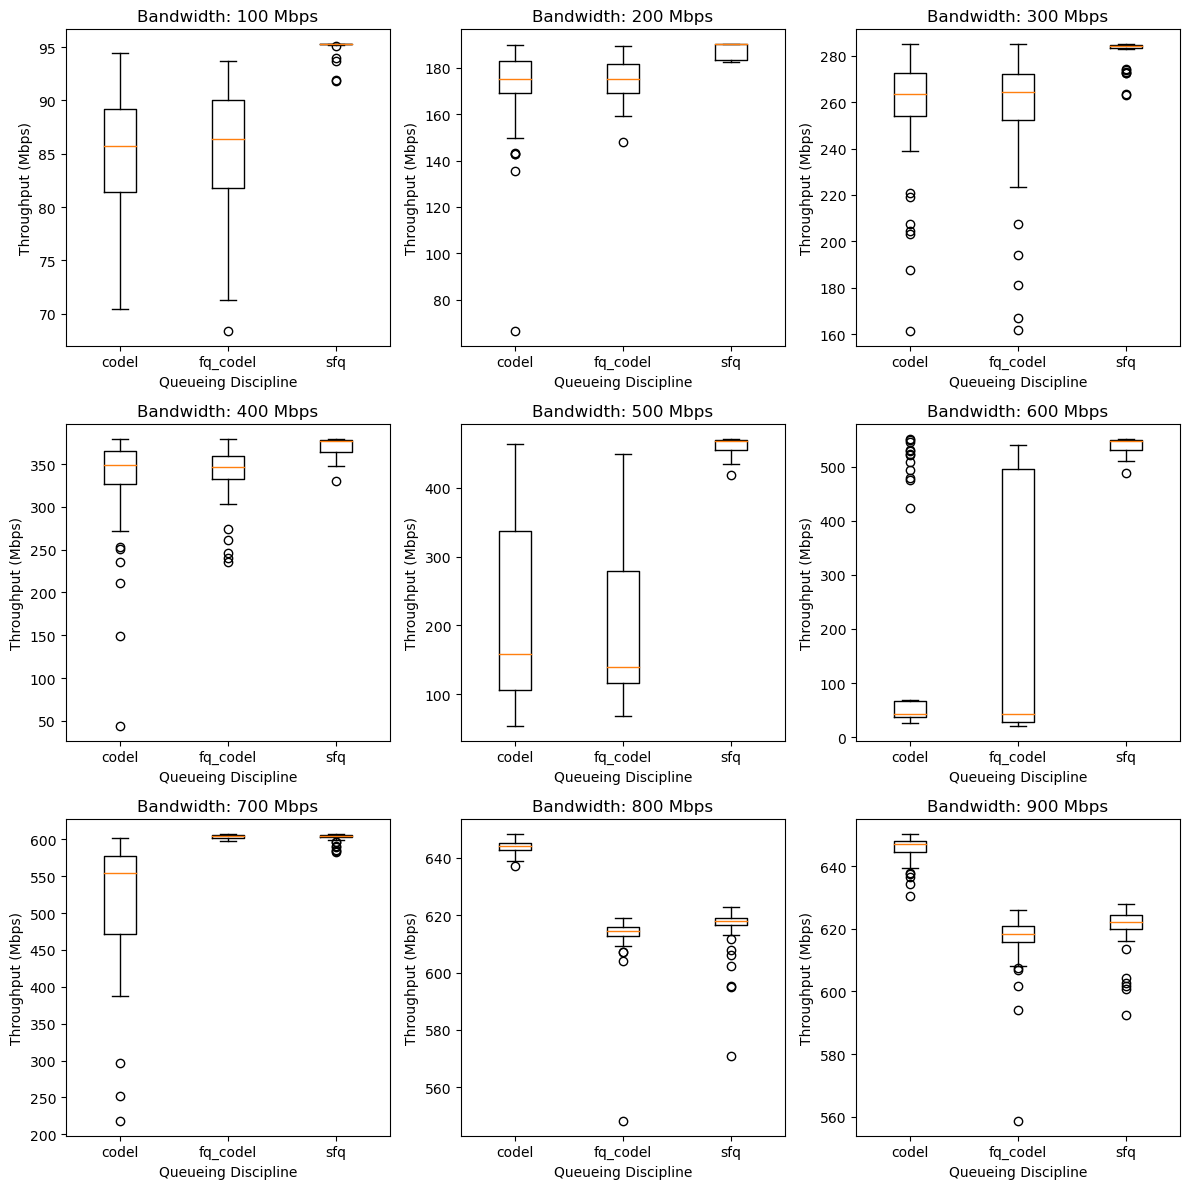

In [ ]:
fig = generate_boxplots(final_df, "upload_throughput_value", "Throughput (Mbps)")

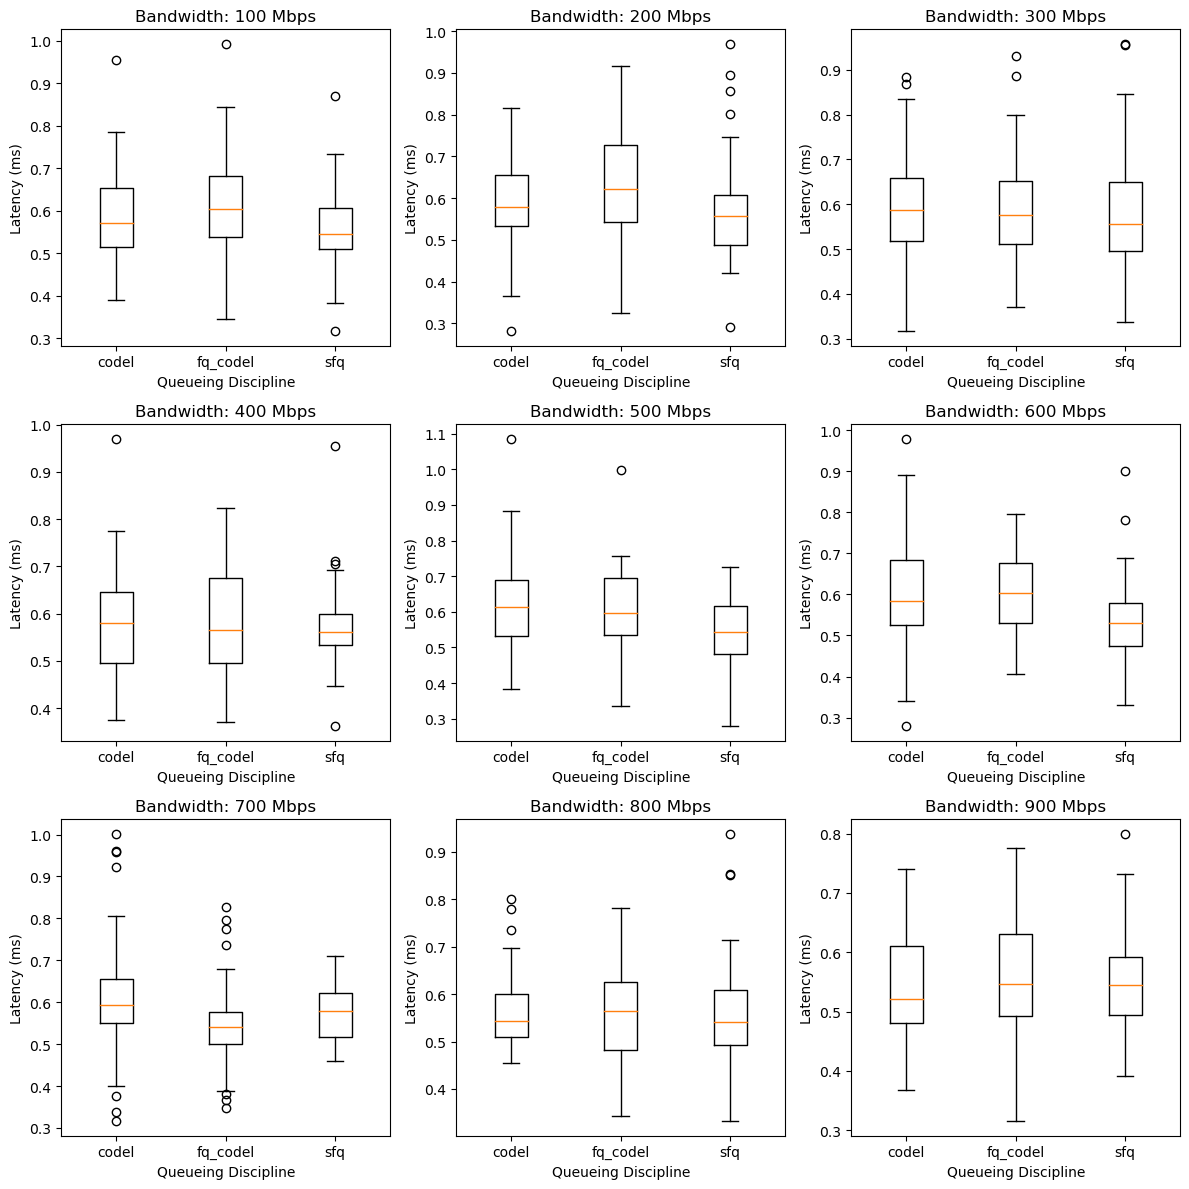

In [7]:
generate_boxplots(final_df, "upload_latency_value_2", "Latency (ms)")

In [13]:

def generate_ecdfs(df, result_col, result_label):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, (speed, speed_df) in enumerate(sorted(df.groupby("speed"))):
        ax = axes[i//3][i%3]
        for aqm, aqm_df in sorted(speed_df.groupby("aqm")):
            sns.ecdfplot(aqm_df[result_col], label=aqm, ax=ax)
        ax.set_xlabel(result_label)
        ax.set_ylabel("CDF")
        ax.set_title(f"Bandwidth: {speed} Mbps")
        ax.legend()
    plt.tight_layout()
    return fig


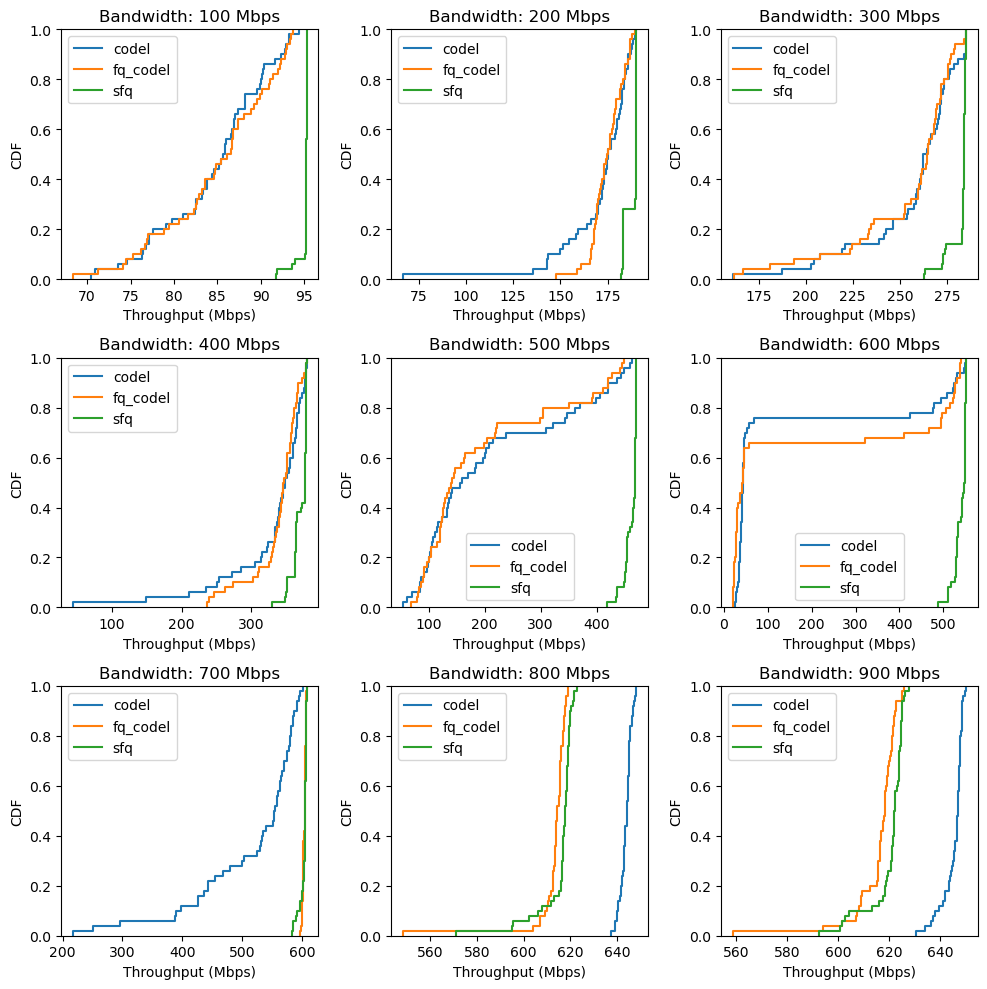

In [14]:
fig = generate_ecdfs(final_df, "upload_throughput_value", "Throughput (Mbps)")

fig.savefig("figures/cdf_tput_estimate.png")

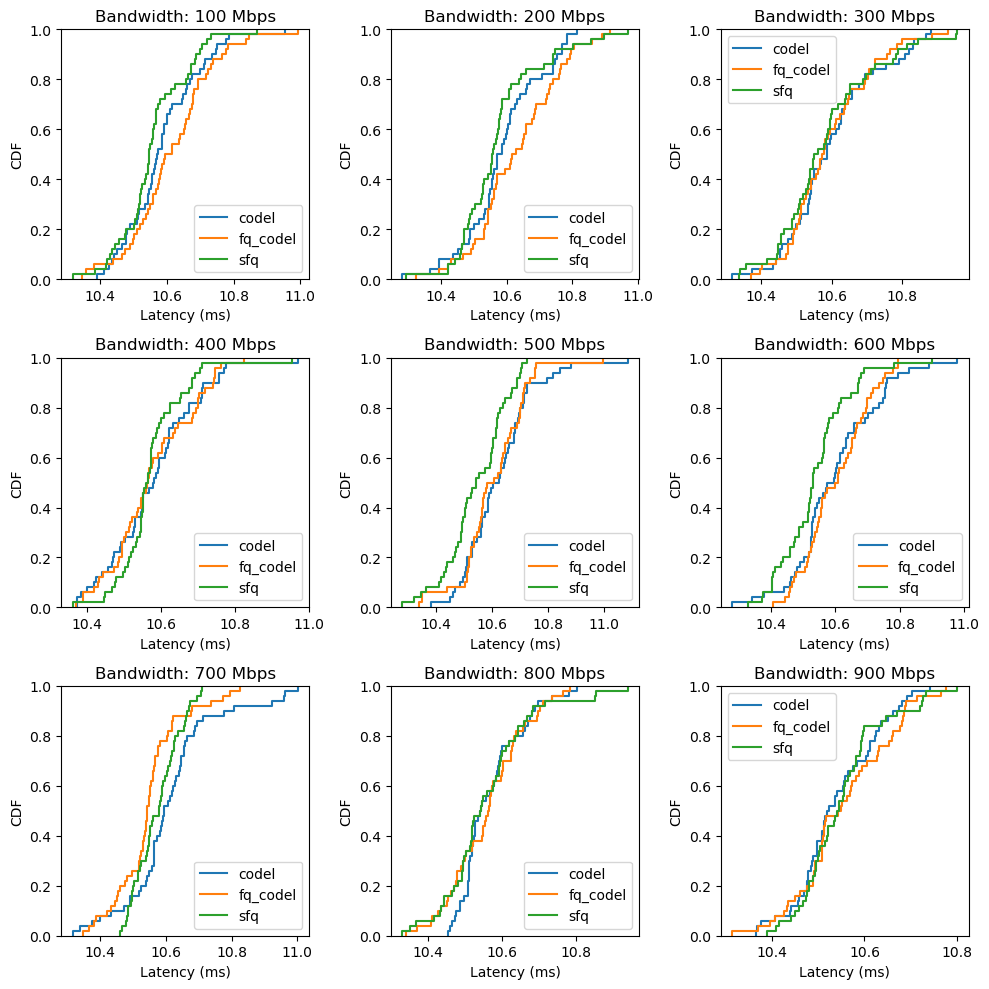

In [11]:
generate_ecdfs(final_df, "upload_latency_value", "Latency (ms)")